<a href="https://colab.research.google.com/github/Pehlevan-Group/sgd_structured_features/blob/main/CIFAR_scalings_feature_space_SGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://www.github.com/google/neural-tangents

import numpy as np
import math
import matplotlib.pyplot as plt
import jax.numpy as jnp

from jax import random
from jax.experimental import optimizers
from jax.api import jit, grad, vmap
import functools
import neural_tangents as nt
from neural_tangents import stax
import sys

from jax.config import config
config.update("jax_debug_nans", True)


import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from google.colab import drive
import scipy as sp
import scipy.optimize
import pandas as pd
from jax.config import config
config.update("jax_enable_x64", True)

from jax.experimental.ode import odeint

#drive.mount('/content/gdrive', force_remount=True)
#root_dir = "/content/gdrive/My Drive/"

In [ ]:
!pip install wandb
import wandb
!wandb login

     |████████████████████████████████| 1.8MB 13.0MB/s 
     |████████████████████████████████| 102kB 12.3MB/s 
     |████████████████████████████████| 133kB 48.9MB/s 
     |████████████████████████████████| 163kB 49.9MB/s 
     |████████████████████████████████| 71kB 10.1MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=2d1fd2d883dd151705c8971a0ddaae064de62280ff2204b33bbdabfbe1c44619
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=9f448c185f51f3e4615f5b36c6091738648aa11f954bc22f51bc966e0d256443
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: 

In [ ]:
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Mounted at /content/gdrive


In [ ]:
# Download CIFAR-10
num_tot = 50000
num_classes = 10
name = 'cifar10'
ds = tfds.load(name, split=tfds.Split.TRAIN).shuffle(1024).batch(num_tot)

plt.rcParams.update({'font.size': 12})

for i,ex in enumerate(ds):
  Xtf = ex['image']
  image = Xtf.numpy() / 255.0
  X = np.reshape(image, (image.shape[0], image.shape[1]*image.shape[2]*image.shape[3]))
  image = jnp.array( image.transpose((0,3,1,2)) )
  y = ex['label'].numpy()
  y_mat = np.eye(10)[y]
  break

ds = tfds.load(name, split=tfds.Split.TEST).shuffle(1024).batch(num_tot)

for i,ex in enumerate(ds):
  Xtf_te = ex['image']
  image_test = Xtf_te.numpy() / 255.0
  print(image_test.shape)
  Xte = np.reshape(image_test, (image_test.shape[0], image_test.shape[1]*image_test.shape[2]*image_test.shape[3]))
  image_test = image_test.transpose((0,3,1,2))
  yte = ex['label'].numpy()
  y_mat_te = np.eye(10)[yte]
  break

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompletePPA0LI/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompletePPA0LI/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
(10000, 32, 32, 3)


In [ ]:
def convnet(k, depth, pool = True):
  layers = []
  for l in range(depth):
    #layers += [stax.Conv(k, (3, 3), (1,1)), stax.Relu()]
    layers += [stax.Conv(k, (3,3), padding='SAME'), stax.Relu()]
    if pool == True:
      layers += [stax.AvgPool((2,2), strides = (2,2))]
  layers += [stax.Flatten(), stax.Dense(10)]
  return stax.serial(*layers)

#init_fn, apply_fn, kernel_fn=convnet(200,2)
#kernel_fn_batched = nt.batch(kernel_fn, batch_size=250)

#_, _, kernel_fn_non = convnet(200,2, pool=False)
#kernel_fn_batched_non = nt.batch(kernel_fn, batch_size=250)


def fully_connected(width, depth):
  layers = []
  for l in range(depth):
    layers += [stax.Dense(width), stax.Relu()]
  layers += [stax.Dense(10)]
  return stax.serial(*layers)



def WideResnetBlock(channels, strides=(1, 1), channel_mismatch=False):
  Main = stax.serial(
      stax.Relu(), stax.Conv(channels, (3, 3), strides, padding='SAME'),
      stax.Relu(), stax.Conv(channels, (3, 3), padding='SAME'))
  Shortcut = stax.Identity() if not channel_mismatch else stax.Conv(
      channels, (3, 3), strides, padding='SAME')
  return stax.serial(stax.FanOut(2),
                     stax.parallel(Main, Shortcut),
                     stax.FanInSum())

def WideResnetGroup(n, channels, strides=(1, 1)):
  blocks = []
  blocks += [WideResnetBlock(channels, strides, channel_mismatch=True)]
  for _ in range(n - 1):
    blocks += [WideResnetBlock(channels, (1, 1))]
  return stax.serial(*blocks)

def WideResnet(block_size, k, num_classes):
  return stax.serial(
      stax.Conv(16, (3, 3), padding='SAME'),
      WideResnetGroup(block_size, int(16 * k)),
      WideResnetGroup(block_size, int(32 * k), (2, 2)),
      WideResnetGroup(block_size, int(64 * k), (2, 2)),
      stax.AvgPool((8, 8)),
      stax.Flatten(),
      stax.Dense(num_classes, 1., 0.))


def MyrtleNetwork(width, depth, W_std=np.sqrt(2.0), b_std=0.):
  layer_factor = {5: [2, 1, 1], 7: [2, 2, 2], 10: [3, 3, 3]}
  activation_fn = stax.Relu()
  layers = []
  conv = functools.partial(stax.Conv, W_std=W_std, b_std=b_std, padding='SAME')
  
  layers += [conv(width, (3, 3)), activation_fn] * layer_factor[depth][0]
  layers += [stax.AvgPool((2, 2), strides=(2, 2))]
  layers += [conv(width, (3, 3)), activation_fn] * layer_factor[depth][1]
  layers += [stax.AvgPool((2, 2), strides=(2, 2))]
  layers += [conv(width, (3, 3)), activation_fn] * layer_factor[depth][2]
  layers += [stax.AvgPool((2, 2), strides=(2, 2))] * 3
  layers += [stax.Flatten(), stax.Dense(10, W_std, 0.0)]

  return stax.serial(*layers)



#### Reshape image data

In [ ]:

image = jnp.array(image, dtype = jnp.float64).transpose((0,2,3,1))
image_test = jnp.array(image_test, dtype = jnp.float64).transpose((0,2,3,1))
print(image.shape)
print(image_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
width = 5000
depth = 2

all_eigs = []
all_v = []
all_K = []


N_pt = 6000

#_, _, kernel_fn = MyrtleNetwork(width, depth)
_, _, kernel_fn = convnet(width, depth, pool = False)

kbatch =  nt.batch(kernel_fn, batch_size=100)
#kbatch = jit(kbatch, static_argnums=2)
K = kbatch(image[0:N_pt,:,:,:], None, 'ntk')


all_K += [K]
eigs, vec = jnp.linalg.eigh(K)

v = jnp.sum( ( 1/vec.shape[0] * vec.T @ y_mat[0:N_pt,:])**2 , axis = 1)
indsort = jnp.argsort(eigs)[::-1]

all_eigs += [ eigs[indsort] ]
all_v += [ v[indsort] ]

_, _, kernel_mlp = fully_connected(width, depth)
Data = image[0:N_pt,:,:,:].reshape((N_pt, image.shape[1]*image.shape[2]*image.shape[3]))
kbatch_mlp = nt.batch(kernel_mlp, batch_size=200)
K_mlp = kernel_mlp(Data, None, 'ntk')
eig_mlp, vec_mlp= jnp.linalg.eigh(K_mlp)
indsort = jnp.argsort(eig_mlp)[::-1]

v = jnp.sum( ( 1/vec.shape[0] * vec_mlp.T @ y_mat[0:N_pt,:])**2 , axis = 1)
all_eigs += [ eig_mlp[indsort] ]
all_v += [ v[indsort] ] 

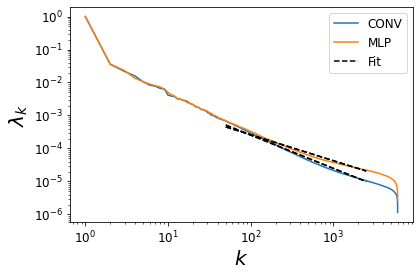

[1.008635010215918, 0.7868183179574973]


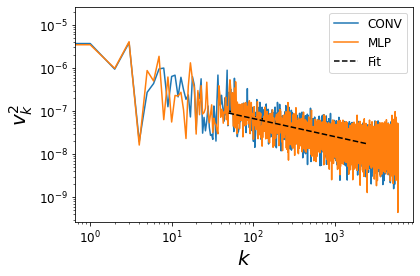

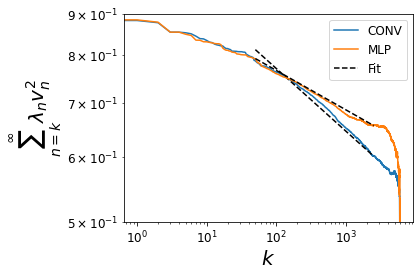

[0.07671703648705944, 0.0482533345423585]


In [ ]:
def extract_power_law(spec, start=0, end=None, xarr = []):
  if end == None:
    end = len(spec)
  inds= np.linspace(start, end, end - start) 
  if len(xarr) > 0:
    inds = xarr[start:end]
  beta = - np.cov(np.log(inds), np.log(spec[start:end]))[0,1] / np.var(np.log(inds))
  return beta

labels = ['CONV', 'MLP']
all_b = []
start = 50
end = 2500

for i,eigs in enumerate(all_eigs):
  b_i = extract_power_law( eigs, start,end)
  eig_i = eigs/eigs[0]
  
  pred =  np.linspace(start,end, end-start)**(-b_i)
  pred = pred * np.mean(eig_i[start:end]) /  np.mean(pred)
  plt.loglog( np.linspace(1,len(all_eigs[i]), len(all_eigs[i])), eig_i , label = labels[i])
  plt.loglog( np.linspace(start, end, end-start), pred  , '--', color = 'black')
  if i == len(all_v)-1:
    plt.loglog( np.linspace(start,end, end-start), pred, '--', color = 'black', label = 'Fit' )
  else:
    plt.loglog( np.linspace(start,end, end-start), pred, '--', color = 'black' )

  all_b += [b_i]
plt.xlabel(r'$k$',fontsize = 20)
plt.ylabel(r'$\lambda_k$',fontsize =20)
#plt.title('Kernel Eigenvalues', fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig(root_dir + 'cifar_conv_vs_MLP_spectra_scaling_exponents.pdf')
plt.show()
print(all_b)

all_a = []

for i, v in enumerate(all_v): 
  plt.loglog(v, label = labels[i])
  a_i = extract_power_law( v, start,end)
  all_a += [a_i]
  pred = np.linspace(start,end, end-start)**(-a_i)
  pred = pred/np.mean(pred) * np.mean(v[start:end])
  if i == len(all_v)-1:
    plt.loglog( np.linspace(start,end, end-start), pred, '--', color = 'black', label = 'Fit' )
  else:
    plt.loglog( np.linspace(start,end, end-start), pred, '--', color = 'black' )

plt.xlabel(r'$k$',fontsize = 20)
plt.ylabel(r'$v_k^2$',fontsize =20)
#plt.title('Task Power Spectrum', fontsize= 20)
plt.legend()
plt.tight_layout()
plt.savefig(root_dir + 'cifar_conv_vs_MLP_task_scaling_exponents.pdf')
plt.show()


all_a2 = []
for i, v in enumerate(all_v): 
  cum_v = np.cumsum(v) / np.sum(v)
  acumv = ( 1-cum_v ) * len(cum_v) / (10+len(cum_v) - np.linspace(1,len(cum_v), len(cum_v)))
  a_i = extract_power_law( acumv, start,end)
  all_a2 += [a_i]
  pred = np.linspace(start,end, end-start)**(-a_i)
  pred = pred/np.mean(pred) * np.mean(1-cum_v[start:end])
  pred = pred * acumv[end] / pred[-1]
  plt.loglog(acumv, label = labels[i])

  if i == len(all_v)-1:
    plt.loglog( np.linspace(start,end, end-start), pred, '--', color = 'black', label = 'Fit' )
  else:
    plt.loglog( np.linspace(start,end, end-start), pred, '--', color = 'black' )


plt.xlabel(r'$k$',fontsize = 20)
plt.ylabel(r'$\sum_{n=k}^\infty \lambda_n v_n^2 $',fontsize =20)
plt.ylim([0.5,0.9])
#plt.title('Task Power Spectrum', fontsize= 20)
plt.legend()
plt.tight_layout()
plt.savefig(root_dir + 'cifar_conv_vs_MLP_task_scaling_exponents_tailsum_better_title.pdf')
plt.show()
print(all_a2)



In [ ]:
import timeit
def train_model(params, apply_fn, learning_rate=0.001, batch_size = 25, num_step = 2500, conv=True):

  
  loss = jit( lambda params, Xtr, ytr: 10*jnp.mean(  ( apply_fn(params, Xtr) - ytr)**2  ) )
  test_loss = jit( lambda params: 10*jnp.mean( ( apply_fn(params, image_test[0:500,:,:,:]) - y_mat_te[0:500,:])**2  ) )
  if conv == False:
    test_loss = jit( lambda params: 10*jnp.mean( ( apply_fn(params, Xte[0:500,:]) - y_mat_te[0:500,:])**2  ) )

  grad_fn  = jit(grad(loss, 0))
  
  opt_init, opt_update, get_params = optimizers.adam(learning_rate)
  opt_state = opt_init(params)
  train = []
  test = []
  start = timeit.default_timer()
  for t in range(num_step):
    start = (batch_size * t) % 50000
    if conv == True:
      D_t = image[start:start+batch_size,:,:,:]
    else:
      D_t = X[start:start+batch_size,:]
    y_t = y_mat[start:start+batch_size,:]
    opt_state = opt_update(t, grad_fn(get_params(opt_state), D_t, y_t) , opt_state)
    #train_loss = loss(get_params(opt_state),  D_t, y_t )
    #train += [train_loss]

    #wandb.log({'train-loss': np.array(train_loss), 'test-loss': np.array(test_loss(get_params(opt_state))) })
    if t % 100 == 0:
      test  += [test_loss(get_params(opt_state))]
      sys.stdout.write('\r t = %d | train: %0.4f | test = %0.4f' % (t, loss(get_params(opt_state),  D_t, y_t ), test[-1]))
      
  return train, test

### Train MLP and Conv net to compare

In [ ]:
width = 512
num_step = 12000
init_fn, apply_fn, _ = fully_connected(width, depth)
_, params= init_fn(random.PRNGKey(0), (-1, 3*32**2))
train_mlp, test_mlp = train_model(params, apply_fn, num_step = num_step, conv=False)

 t = 11900 | train: 0.6793 | test = 0.7022

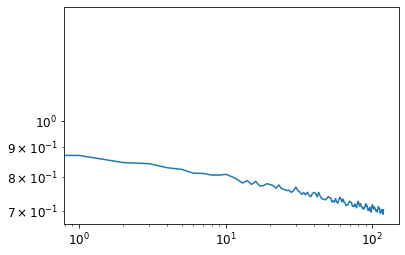

In [ ]:
plt.loglog(test_mlp)
plt.show()

In [ ]:
width = 50
num_step = 12000
print(image_test.shape)
print(image.shape)
init_fn, apply_fn, _ = convnet(width, depth)
_, params= init_fn(random.PRNGKey(0), (-1, 32,32,3))
train_conv, test_conv = train_model(params, apply_fn, learning_rate = 0.01, num_step = num_step, conv=True)

(10000, 32, 32, 3)
(50000, 32, 32, 3)
 t = 11900 | train: 0.6083 | test = 0.5745

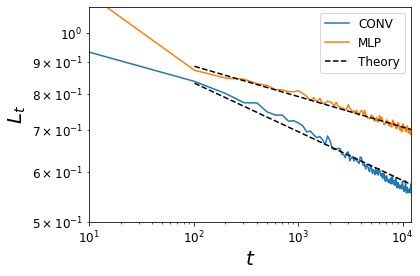

In [ ]:
start = 1
end = 12000
arr = np.linspace(start, end, len(test_conv))

plt.loglog(arr, test_conv, label = labels[0])
plt.loglog(arr, test_mlp, label = labels[1])

scale_1 = arr**(-all_a2[0])
scale_1 = scale_1 / scale_1[-1] * test_conv[-1]

scale_2 = arr**(-all_a2[1])
scale_2 = scale_2 / scale_2[-1] * test_mlp[-1]
plt.loglog(arr[1:], scale_1[1:], '--',color = 'black', label = 'Theory')
plt.loglog(arr[1:], scale_2[1:], '--', color = 'black')
plt.xlabel(r'$t$',fontsize=20)
plt.ylabel(r'$L_t$',fontsize=20)
plt.ylim([5e-1,1.1])
plt.xlim([10,np.amax(arr)])
#plt.title('CIFAR Online Scalings',fontsize=20)
plt.legend()
plt.tight_layout()
plt.savefig(root_dir + 'wide_conv_vs_mlp_cifar_longer.pdf')
plt.show()